# AAut lab question 2 part 1

## Image classification

# Initial steps
Import libraries

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.metrics import confusion_matrix
from PIL import Image, ImageEnhance
from imblearn.over_sampling import SMOTE

Load data

In [2]:
Xtest1 = np.load('Xtest1.npy')
Xtrain1 = np.load('Xtrain1.npy')
Xtrain1_extra = np.load('Xtrain1_extra.npy')
Ytrain1 = np.load('Ytrain1.npy')

Set fixed seed for consistent results

In [42]:
# Set the seed for numpy
np.random.seed(42)

# Set the seed for TensorFlow
tf.random.set_seed(42)

Augment imgages while balacing the dataset

In [4]:
def augment_images(images, labels):
    augmented_images = []
    augmented_labels = []

    # Reshape the images from (2783, 2304) to (2783, 48, 48)
    reshaped_images = images.reshape(-1, 48, 48)

    for img, label in zip(reshaped_images, labels):
        pil_img = Image.fromarray(img)

        # Original image
        augmented_images.append(np.array(pil_img))
        # Horizontal flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_LEFT_RIGHT)))
        # Vertical flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_TOP_BOTTOM)))
        # Rotate 90 degrees
        augmented_images.append(np.array(pil_img.rotate(90)))

        if label == 0:
            # Rotate 180 degrees
            augmented_images.append(np.array(pil_img.rotate(180)))
            # Rotate 270 degrees
            augmented_images.append(np.array(pil_img.rotate(270)))
            # Increase the brightness
            augmented_images.append(np.array(ImageEnhance.Brightness(pil_img).enhance(1.5)))
            # Append the label for each augmented image
            augmented_labels.extend([label] * 7)
        else:
            # Append the label for each augmented image
            augmented_labels.extend([label] * 4)

    # Convert the augmented images back to the (num_images, 2304) format
    augmented_images = np.array(augmented_images).reshape(-1, 48 * 48)
    return augmented_images, augmented_labels

In [54]:
def augment_images_smote(images, labels):
    augmented_images = []
    augmented_labels = []

    # Reshape the images from (2783, 2304) to (2783, 48, 48)
    reshaped_images = images.reshape(-1, 48, 48)

    for img, label in zip(reshaped_images, labels):
        pil_img = Image.fromarray(img)

        # Original image
        augmented_images.append(np.array(pil_img))
        # Horizontal flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_LEFT_RIGHT)))
        # Vertical flip
        augmented_images.append(np.array(pil_img.transpose(Image.FLIP_TOP_BOTTOM)))
        # Rotate 90 degrees
        augmented_images.append(np.array(pil_img.rotate(90)))
        # Rotate 180 degrees
        augmented_images.append(np.array(pil_img.rotate(180)))
        # Rotate 270 degrees
        augmented_images.append(np.array(pil_img.rotate(270)))
        # Increase the brightness
        augmented_images.append(np.array(ImageEnhance.Brightness(pil_img).enhance(1.5)))
        # Append the label for each augmented image
        augmented_labels.extend([label] * 7)

    # Convert the augmented images back to the (num_images, 2304) format
    augmented_images = np.array(augmented_images).reshape(-1, 48 * 48)
    return augmented_images, augmented_labels

Function to plot images

In [5]:
# Function to plot images
def plot_images(images, labels, num_images=20, extra=0):
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i].reshape(48, 48), cmap='gray')
        if extra:
            plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

Augment data

(14150, 48, 48, 1)
(2783,)


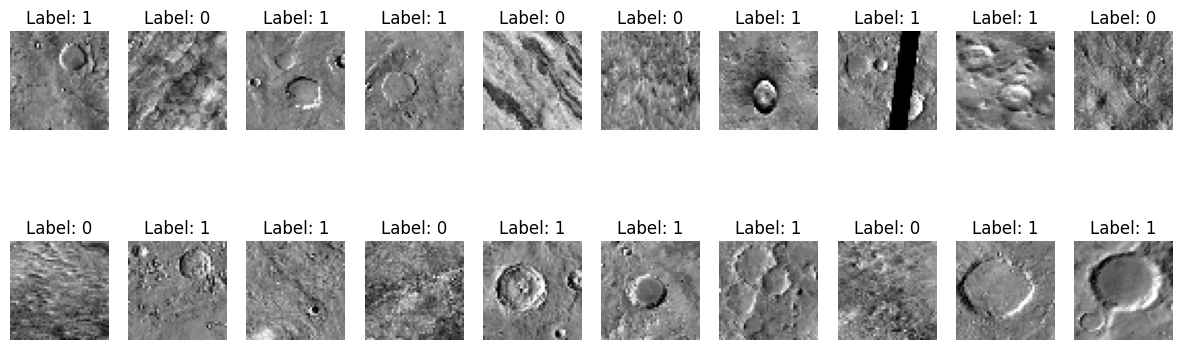

In [66]:
Xtrain_resampled, Ytrain_resampled = augment_images(Xtrain1, Ytrain1)

Xtrain_resampled_CNN = Xtrain_resampled.reshape(-1, 48, 48, 1)

# Shuffle the dataset
indices = np.arange(Xtrain_resampled_CNN.shape[0])
np.random.shuffle(indices)
Xtrain_resampled_CNN = Xtrain_resampled_CNN[indices]
Ytrain_resampled = np.array(Ytrain_resampled)[indices]

print(Xtrain_resampled_CNN.shape)
print(Ytrain1.shape)

plot_images(Xtrain_resampled_CNN, Ytrain_resampled, extra=1)

(3554, 2304)
(24878, 48, 48, 1)
(2783,)


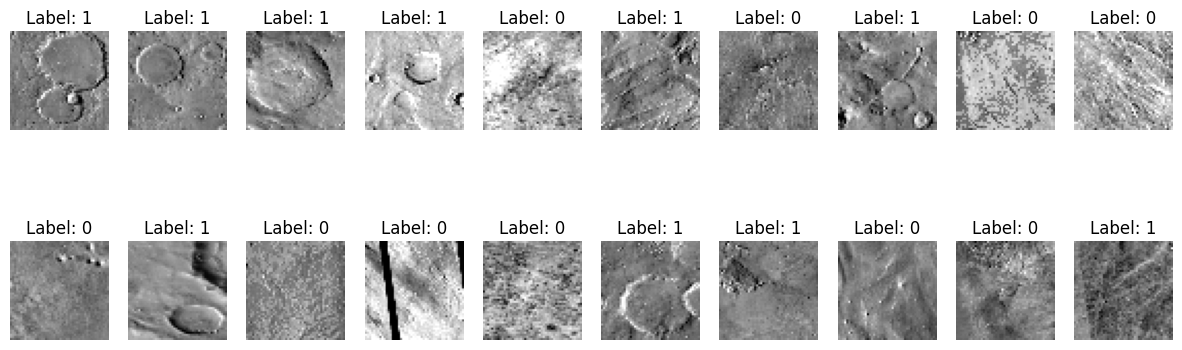

In [62]:
smote = SMOTE()

Xtrain_resampled_smote, Ytrain_resampled_smote = smote.fit_resample(Xtrain1, Ytrain1)
print(Xtrain_resampled_smote.shape)

Xtrain_resampled_smote, Ytrain_resampled_smote = augment_images_smote(Xtrain_resampled_smote, Ytrain_resampled_smote)

Xtrain_resampled_smote = Xtrain_resampled_smote.reshape(-1, 48, 48, 1)

# Shuffle the dataset
indices = np.arange(Xtrain_resampled_smote.shape[0])
np.random.shuffle(indices)
Xtrain_resampled_smote = Xtrain_resampled_smote[indices]
Ytrain_resampled_smote = np.array(Ytrain_resampled_smote)[indices]

print(Xtrain_resampled_smote.shape)
print(Ytrain1.shape)

plot_images(Xtrain_resampled_smote, Ytrain_resampled_smote, extra=1)

## Build CNNs

### CNN

In [45]:
# Build a simple CNN model
def build_model_CNN():
    model_CNN = Sequential([
        Input(shape=(48, 48, 1)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5), # model summary

        Dense(2, activation='softmax')
    ])
    # Compile the model
    model_CNN.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return model_CNN

MLP


In [8]:
def build_model_MLP():
    model_MLP = Sequential([
        Input(shape=(2304,)),  # Flatten the input images

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(2, activation='softmax')
    ])
    # Compile the model
    model_MLP.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
    return model_MLP

## Train the models

Callbacks

In [46]:
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-5)

### CNN

In [38]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(Xtrain_resampled_CNN, Ytrain_resampled, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)

In [47]:
# Build the CNN model
model_CNN = build_model_CNN()

# Train the model
history = model_CNN.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - accuracy: 0.8216 - loss: 0.4323 - val_accuracy: 0.6159 - val_loss: 0.6511 - learning_rate: 0.0010
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8901 - loss: 0.2764 - val_accuracy: 0.8110 - val_loss: 0.4367 - learning_rate: 0.0010
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9044 - loss: 0.2356 - val_accuracy: 0.8261 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 4/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9181 - loss: 0.2031 - val_accuracy: 0.7583 - val_loss: 0.5602 - learning_rate: 0.0010
Epoch 5/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9332 - loss: 0.1699 - val_accuracy: 0.8053 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 6/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9405 - loss: 0.1511 - val_accuracy: 0.8032 - val_loss: 0.5773 - learning_rate: 0.0010
Epoch 7/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9562 - loss: 

89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Validation F1 Score: 0.929093567251462


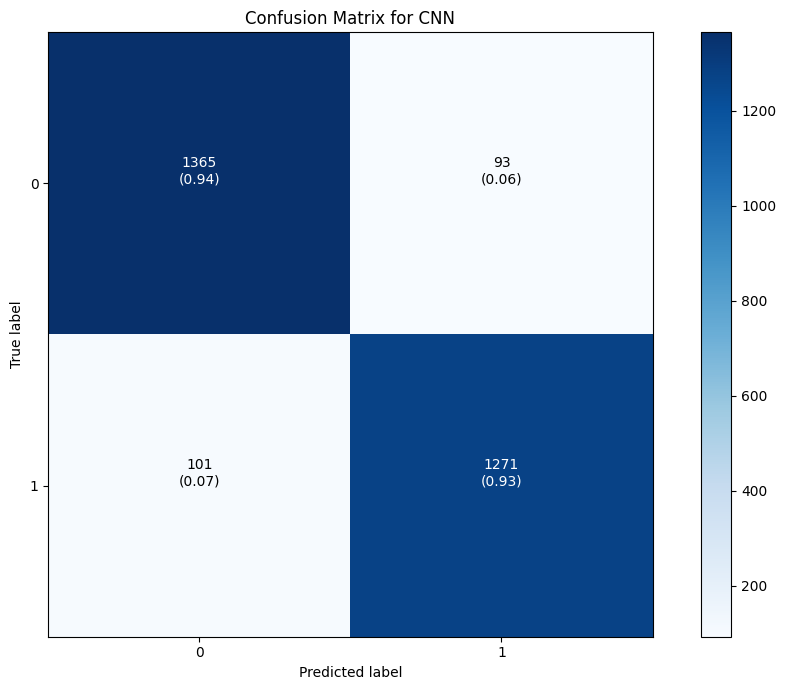

In [48]:
# Predict on the validation set
y_val_pred = model_CNN.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# save the model
model_CNN.save('model_CNN.keras')

# Calculate the F1 score
f1 = f1_score(y_val, y_val_pred_classes)
print(f"Validation F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val))
plt.yticks(tick_marks, np.unique(y_val))

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the numbers inside the matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:d}\n({cm_normalized[i, j]:.2f})",
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [63]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(Xtrain_resampled_smote, Ytrain_resampled_smote, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)

# Build the CNN model
model_CNN_smote = build_model_CNN()

# Train the model
history = model_CNN_smote.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - accuracy: 0.8206 - loss: 0.4410 - val_accuracy: 0.8227 - val_loss: 0.4504 - learning_rate: 0.0010
Epoch 2/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8933 - loss: 0.2643 - val_accuracy: 0.7840 - val_loss: 0.6509 - learning_rate: 0.0010
Epoch 3/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9085 - loss: 0.2301 - val_accuracy: 0.5430 - val_loss: 2.3437 - learning_rate: 0.0010
Epoch 4/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9239 - loss: 0.1921 - val_accuracy: 0.6395 - val_loss: 1.0264 - learning_rate: 0.0010
Epoch 5/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9380 - loss: 0.1570 - val_accuracy: 0.8390 - val_loss: 0.4813 - learning_rate: 0.0010
Epoch 6/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9534 - loss: 0.1229 - val_accuracy: 0.8593 - val_loss: 0.5287 - learning_rate: 0.0010
Epoch 7/100
622/622 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9614 - los

156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation F1 Score: 0.9547474747474748


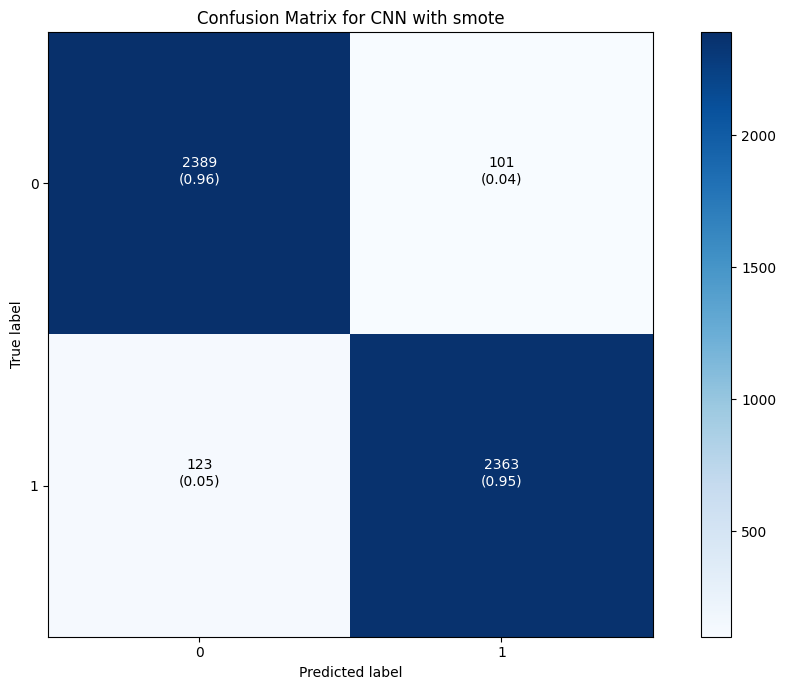

In [72]:
# Predict on the validation set
y_val_pred = model_CNN_smote.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate the F1 score
f1 = f1_score(y_val, y_val_pred_classes)
print(f"Validation F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN with smote')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val))
plt.yticks(tick_marks, np.unique(y_val))

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the numbers inside the matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:d}\n({cm_normalized[i, j]:.2f})",
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

MLP

In [31]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(Xtrain_resampled, Ytrain_resampled, test_size=0.2, random_state=42)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)

model_MLP = build_model_MLP()
history = model_MLP.fit(X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.5013 - loss: 1.0426 - val_accuracy: 0.5014 - val_loss: 0.6999 - learning_rate: 0.0010
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.5131 - loss: 0.7315 - val_accuracy: 0.4873 - val_loss: 0.7016 - learning_rate: 0.0010
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5006 - loss: 0.7059 - val_accuracy: 0.4975 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 4/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5121 - loss: 0.6991 - val_accuracy: 0.4898 - val_loss: 0.6992 - learning_rate: 0.0010
Epoch 5/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5128 - loss: 0.6989 - val_accuracy: 0.4961 - val_loss: 0.7111 - learning_rate: 0.0010
Epoch 6/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5211 - loss: 0.6989 - val_accuracy: 0.4958 - val_loss: 0.7196 - learning_rate: 0.0010
Epoch 7/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5319 - loss:

89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5101 - loss: 0.6983
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Validation F1 Score: 0.5047385047385048


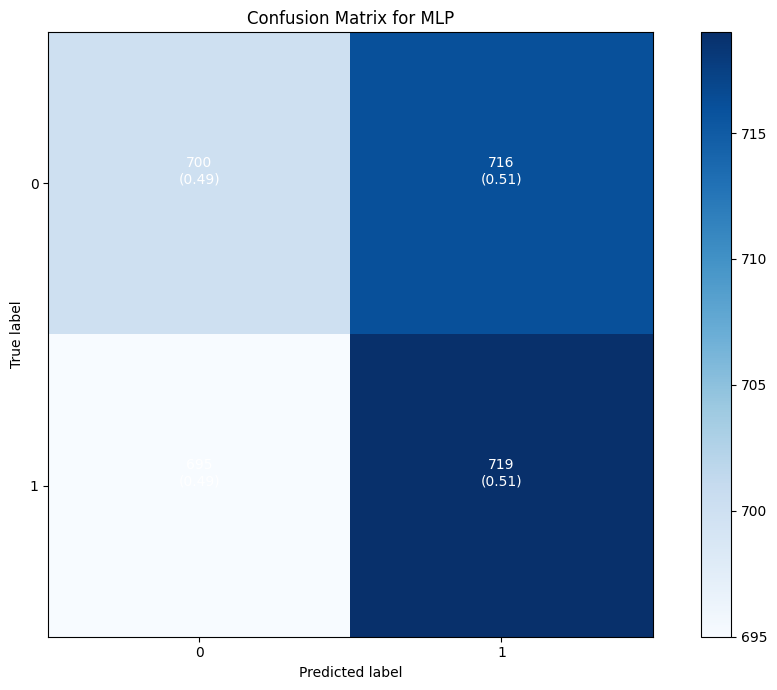

In [32]:
# Predict on the validation set
y_val_pred = model_MLP.predict(X_val)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)

# Calculate the F1 score
f1 = f1_score(y_val, y_val_pred_classes)
print(f"Validation F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(y_val, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for MLP')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val))
plt.yticks(tick_marks, np.unique(y_val))

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the numbers inside the matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:d}\n({cm_normalized[i, j]:.2f})",
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

KNN

In [69]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Reshape the data for KNN
Xtrain_knn = Xtrain_resampled.reshape(Xtrain_resampled.shape[0], -1)

# Create and train the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

# train test split
Xtrain_knn, Xval_knn, Ytrain_resampled, Yval_resampled = train_test_split(Xtrain_knn, Ytrain_resampled, test_size=0.2, random_state=42)

knn_model.fit(Xtrain_knn, Ytrain_resampled)

# Predict on the validation set
y_val_pred = knn_model.predict(Xval_knn)

# Calculate the F1 score
f1 = f1_score(Yval_resampled, y_val_pred)
print(f"Validation F1 Score: {f1}")

Validation F1 Score: 0.5197324414715719


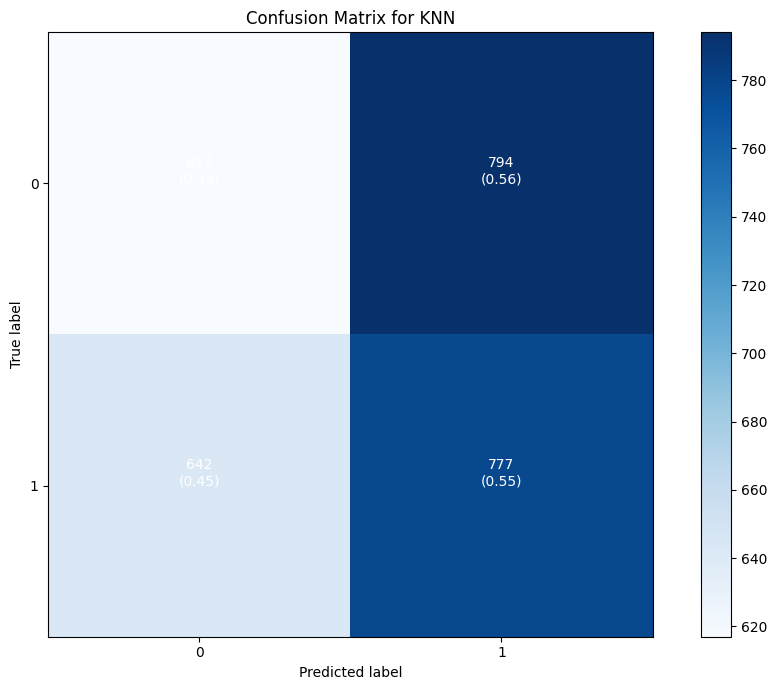

In [70]:
# Compute the confusion matrix
cm = confusion_matrix(Yval_resampled, y_val_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val))
plt.yticks(tick_marks, np.unique(y_val))

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the numbers inside the matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:d}\n({cm_normalized[i, j]:.2f})",
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

## Evaluation of the models

### Run the model

Retrain with extra data

In [49]:
Xtrain1_extra = Xtrain1_extra.reshape(-1, 48, 48, 1)
predY = model_CNN.predict(Xtrain1_extra)
predY_classes = np.argmax(predY, axis=1)

Xtrain1_extra_resampled, Ytrain1_extra_resampled = augment_images(Xtrain1_extra, predY_classes)
Xtrain1_extra_resampled = Xtrain1_extra_resampled.reshape(-1, 48, 48, 1)

Xtrain_final = np.concatenate((Xtrain_resampled_CNN, Xtrain1_extra_resampled), axis=0)
Ytrain_final = np.concatenate((Ytrain_resampled, Ytrain1_extra_resampled), axis=0)
print(Xtrain_final.shape)
print(Ytrain_final.shape)

# Shuffle the dataset
indices = np.arange(Xtrain_final.shape[0])
np.random.shuffle(indices)
Xtrain_final = Xtrain_final[indices]
Ytrain_final = np.array(Ytrain_final)[indices]

unique, counts = np.unique(Ytrain_final, return_counts=True)

print("Quantity of 0s:", counts[0])  # Assuming 0 is the first unique value
print("Quantity of 1s:", counts[1])  # Assuming 1 is the second unique value

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(19797, 48, 48, 1)
(19797,)
Quantity of 0s: 11781
Quantity of 1s: 8016


In [50]:
trainX, valX, trainY, valY = train_test_split(Xtrain_final, Ytrain_final, test_size=0.2, random_state=42)

# Convert the labels to one-hot encoded vectors
trainY_cat = to_categorical(trainY)
valY_cat = to_categorical(valY)

# Build the model
model = build_model_CNN()

# Train the model
history = model.fit(trainX, trainY_cat, validation_data=(valX, valY_cat), epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Save the model
model.save('final_model.keras')

Epoch 1/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.8269 - loss: 0.4141 - val_accuracy: 0.5967 - val_loss: 1.4723 - learning_rate: 0.0010
Epoch 2/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.8864 - loss: 0.2780 - val_accuracy: 0.8086 - val_loss: 0.4230 - learning_rate: 0.0010
Epoch 3/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9041 - loss: 0.2406 - val_accuracy: 0.7111 - val_loss: 0.6468 - learning_rate: 0.0010
Epoch 4/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9159 - loss: 0.2087 - val_accuracy: 0.6126 - val_loss: 1.0525 - learning_rate: 0.0010
Epoch 5/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9294 - loss: 0.1791 - val_accuracy: 0.6187 - val_loss: 1.1820 - learning_rate: 0.0010
Epoch 6/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9422 - loss: 0.1479 - val_accuracy: 0.8523 - val_loss: 0.3653 - learning_rate: 0.0010
Epoch 7/100
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9537 - loss:

124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[1 1 0 ... 1 1 0]
[1 1 0 ... 1 1 0]
Validation F1 Score: 0.8894933696021762


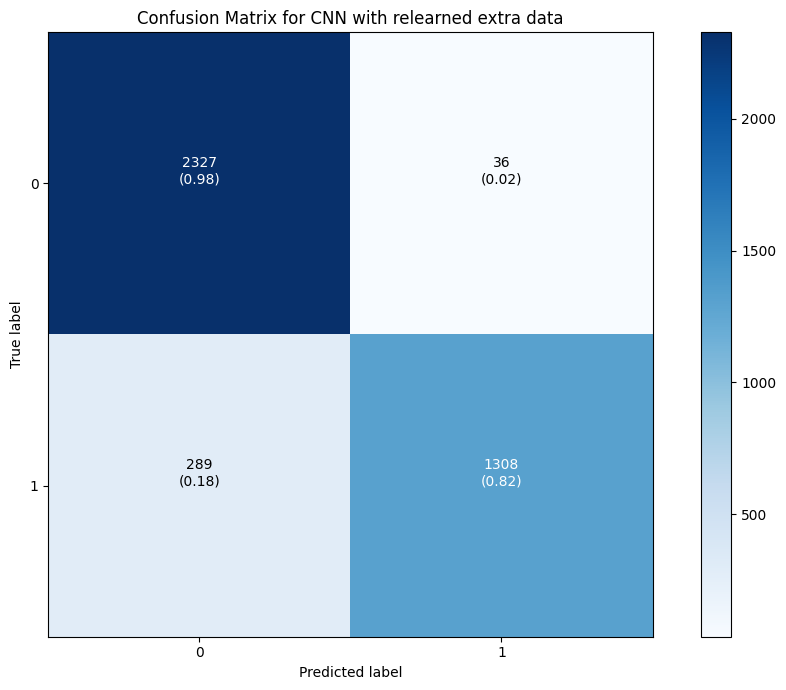

In [51]:
# Predict on the validation set
y_val_pred = model.predict(valX)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
print(y_val_pred_classes)
print(valY)
# Calculate the F1 score
f1 = f1_score(valY, y_val_pred_classes)
print(f"Validation F1 Score: {f1}")

# Compute the confusion matrix
cm = confusion_matrix(valY, y_val_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN with relearned extra data')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_val)))
plt.xticks(tick_marks, np.unique(y_val))
plt.yticks(tick_marks, np.unique(y_val))

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Print the numbers inside the matrix
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, f"{cm[i, j]:d}\n({cm_normalized[i, j]:.2f})",
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

### Final predictions

In [52]:
Xtest1 = Xtest1.reshape(-1, 48, 48, 1)
predY_final = model_CNN.predict(Xtest1)
predY_classes_final = np.argmax(predY_final, axis=1)
print(predY_classes_final)
# Save the predictions with np
np.save('predY_classes_final.npy', predY_classes_final)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1
 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0
 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0
 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0
 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0
 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0
 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1
 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0
 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1
 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0

In [71]:
predY_final_smote = model_CNN_smote.predict(Xtest1)
predY_classes_final_smote = np.argmax(predY_final_smote, axis=1)
print(predY_classes_final)
# Save the predictions with np
np.save('predY_classes_final_smote.npy', predY_classes_final)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
[0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 1
 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 0 1 0 1 0
 1 1 1 1 1 1 1 0 0 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0
 1 1 1 0 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0
 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 0
 1 0 0 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 1 1 0 1 0
 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1
 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0
 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1
 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1
 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0